In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


In [6]:
df = pd.read_pickle("../data/reviews_vector.pkl")

In [7]:
X=df[df.columns[4:]]
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [9]:
# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train_transformed, y_train)

In [10]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


binary
0    148641
1    563714
Name: count, dtype: int64


Resampled class distribution


binary
0    563714
1    563714
Name: count, dtype: int64

from the [imblearn.pipeline.Pipeline](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html)

In [13]:

estimators = [('normalise', StandardScaler()),
              ('smote', SMOTE(random_state=1)),
              ('model', DecisionTreeClassifier(max_depth=15, random_state=12))]

pipe = ImPipeline(estimators, verbose=True)

# pipe = Pipeline(estimators, verbose = True)
pipe.fit(X_train, y_train)



[Pipeline] ......... (step 1 of 3) Processing normalise, total=   8.2s
[Pipeline] ............. (step 2 of 3) Processing smote, total= 1.6min
[Pipeline] ............. (step 3 of 3) Processing model, total= 1.0min


Pipeline(steps=[('normalise', StandardScaler()),
                ('smote', SMOTE(random_state=1)),
                ('model',
                 DecisionTreeClassifier(max_depth=15, random_state=12))],
         verbose=True)

In [14]:
y_test_pred = pipe.predict(scaler.transform(X_test)) # USING THE UNSAMPLED BUT SCALED TEST DATA


/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
pipe.score(X_test, y_test)

0.6902559955977068

Sparsity: SMOTE might change the inherent sparsity of TF-IDF features by creating synthetic samples with more non-zero values than real text data.

High-Dimensionality: The effectiveness of SMOTE decreases in high-dimensional TF-IDF spaces due to the diminishing significance of nearest neighbors.

Interpretability: Synthetic TF-IDF vectors produced by SMOTE may not correspond to any genuine or meaningful text, challenging the interpretability of the data.

Relevance of Features: SMOTE can inadvertently amplify the influence of less relevant or noisy features in the synthetic samples it generates for TF-IDF data.

In [29]:
# confusion matrix
conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

,predicted 0,predicted 1
true 0,25339,11646
true 1,44152,96952


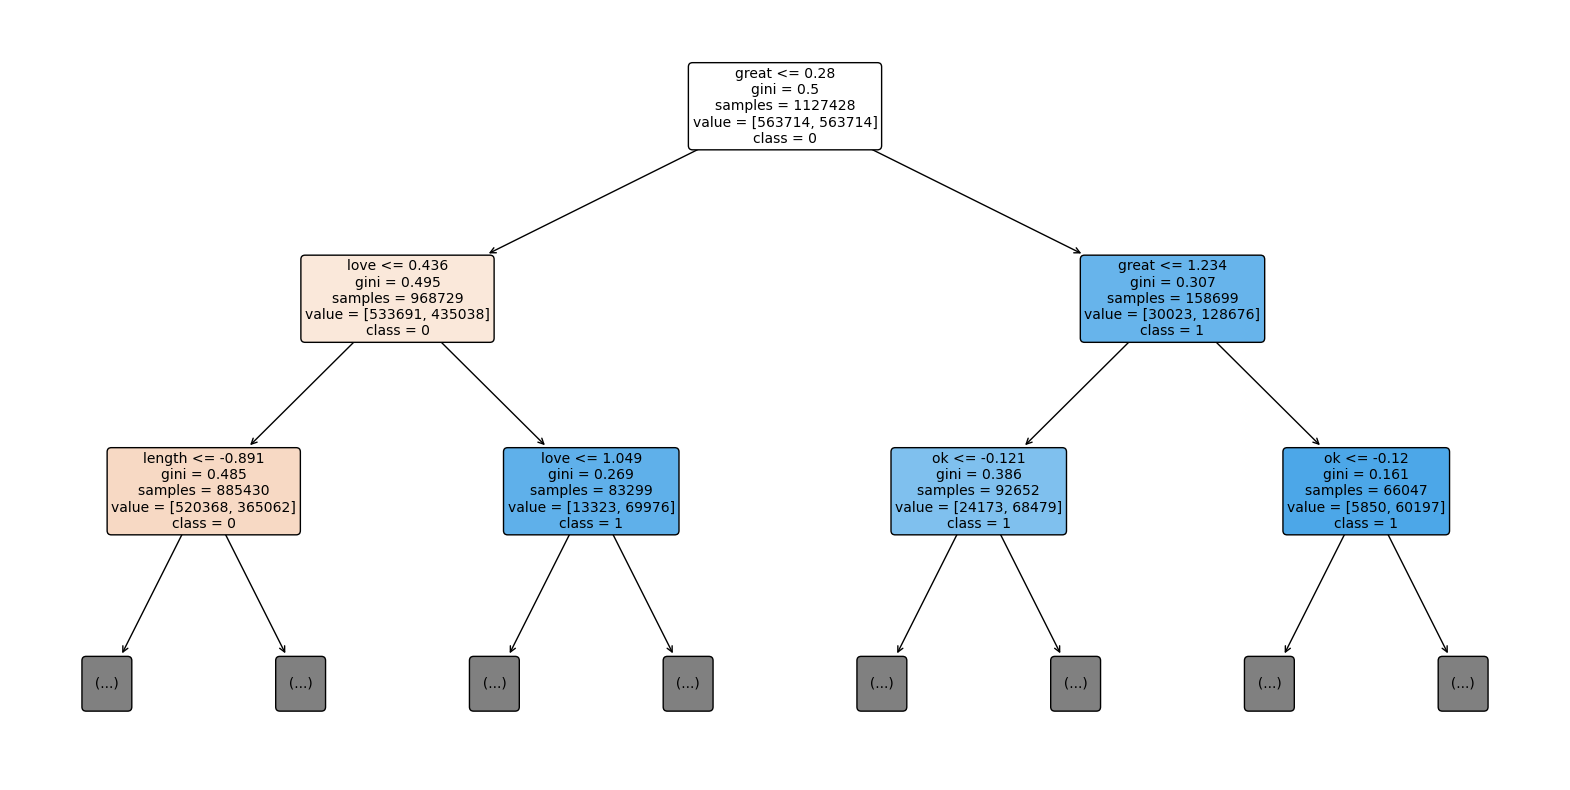

In [28]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier = pipe[-1]

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, max_depth=2, filled=True, feature_names=list(X_train.columns), class_names=["0","1"], rounded=True)
plt.show()

In [17]:

params = {
    'model__max_depth': [5,10,15],
    'model__min_samples_leaf': [3,5,10],
    'model__random_state':[12],
    'normalise': [StandardScaler()]
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=1, n_jobs=-2)

In [17]:
fittedgrid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  50.4s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  51.5s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  51.7s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  52.0s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  52.1s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  52.4s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  52.5s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  52.5s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=  52.6s
[Pipeline] ............. (step 2 of 2) Processing model, total=  36.8s
[Pipeline] ............. (step 2 of 2) Processing model, total=  46.8s
[Pipeline] ............. (step 2 of 2) Processing model, total=  48.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  49.2s
[Pipeline] ......

In [18]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=15, min_samples_leaf=3,
                                        random_state=12))],
         verbose=True)

In [19]:
fittedgrid.best_score_

0.8233324676600852

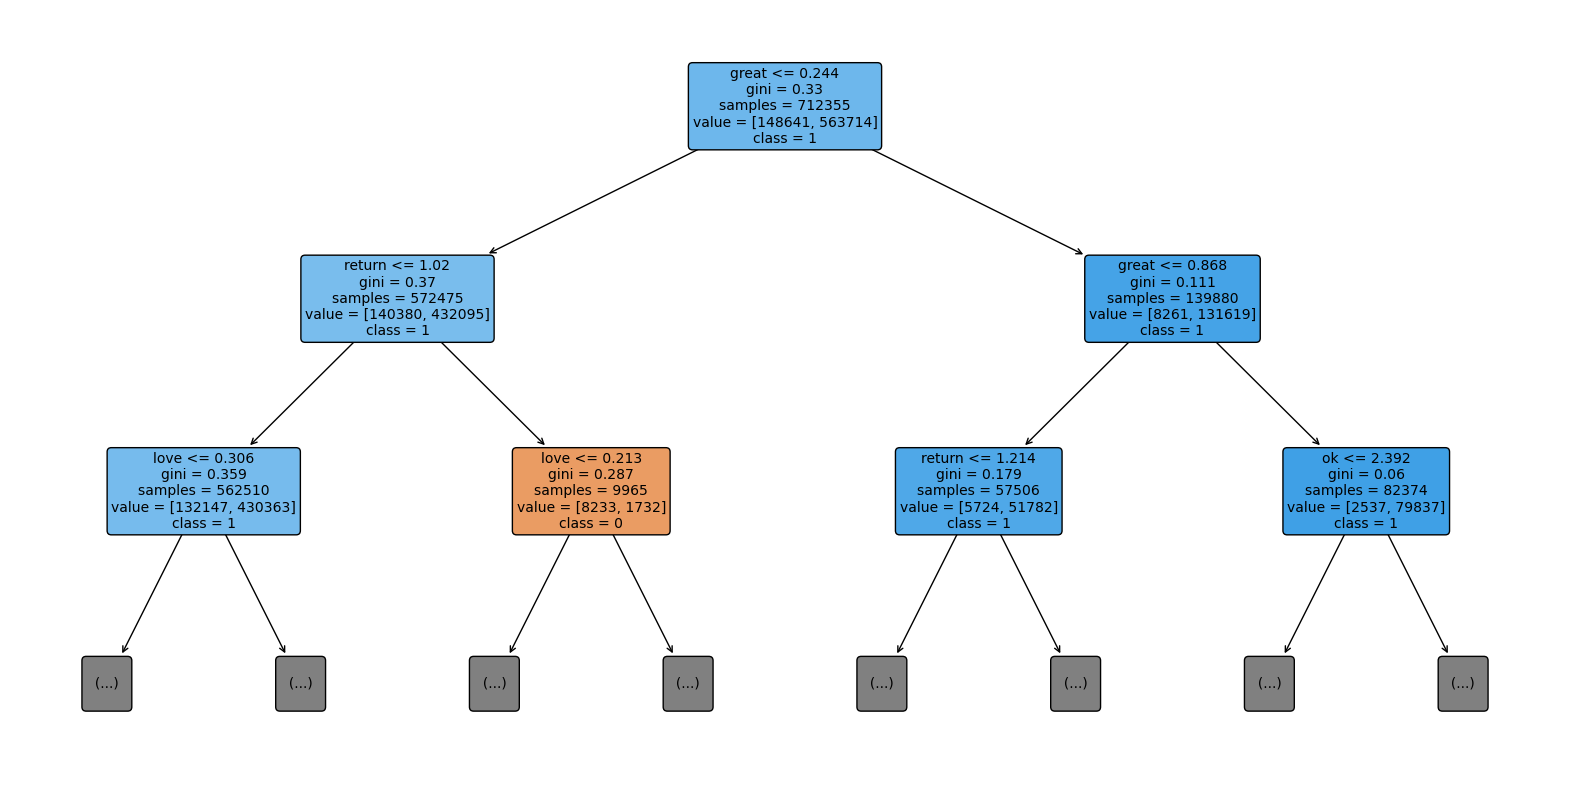

In [24]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier = pipe[-1]

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, max_depth=2, filled=True, feature_names=list(pipe[-2].get_feature_names_out()), class_names=["0","1"], rounded=True)
plt.show()

In [6]:
cross_val_score(pipe, X_train, y_train, cv=5)

[Pipeline] ......... (step 1 of 3) Processing normalise, total=   3.2s
[Pipeline] ........ (step 2 of 3) Processing reduce_dim, total=  19.4s
[Pipeline] ............. (step 3 of 3) Processing model, total=  10.3s
[Pipeline] ......... (step 1 of 3) Processing normalise, total=   3.0s
[Pipeline] ........ (step 2 of 3) Processing reduce_dim, total=  21.5s
[Pipeline] ............. (step 3 of 3) Processing model, total=  10.2s
[Pipeline] ......... (step 1 of 3) Processing normalise, total=   3.1s
[Pipeline] ........ (step 2 of 3) Processing reduce_dim, total=  18.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  10.2s
[Pipeline] ......... (step 1 of 3) Processing normalise, total=   2.9s
[Pipeline] ........ (step 2 of 3) Processing reduce_dim, total=  20.4s
[Pipeline] ............. (step 3 of 3) Processing model, total=  10.3s
[Pipeline] ......... (step 1 of 3) Processing normalise, total=   3.2s
[Pipeline] ........ (step 2 of 3) Processing reduce_dim, total=  19.3s
[Pipel

array([0.81700135, 0.82329035, 0.8248626 , 0.82190762, 0.82385889])

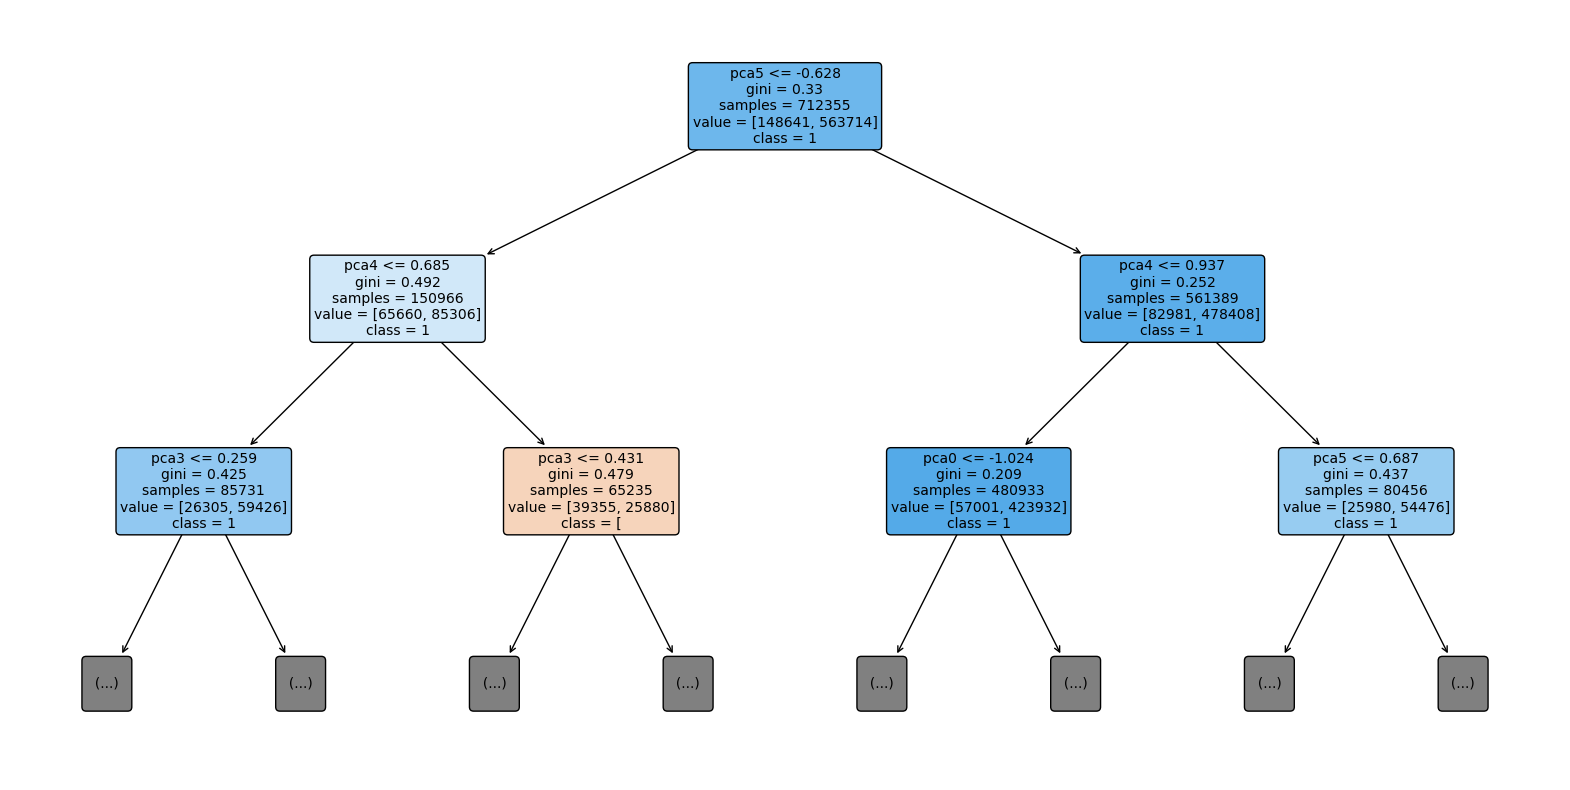

In [7]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier = pipe[-1]

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, max_depth=2, filled=True, feature_names=list(pipe[-2].get_feature_names_out()), class_names=list(str(y_train.unique())), rounded=True)
plt.show()

In [25]:
y_pred_baseline_test= pipe.predict(X_test_transformed)

cm = confusion_matrix(y_test, y_pred_baseline_test)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


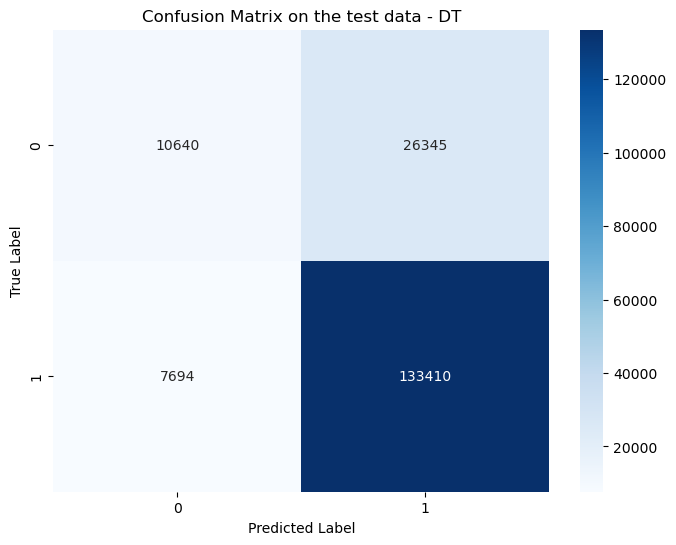

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - DT")
plt.show()